In [11]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

matplotlib.rc('figure', figsize=(8, 6))
matplotlib.rc('axes', edgecolor='k')
matplotlib.rc('grid', color='k', linewidth=0.5, linestyle=':')
matplotlib.rc('font', size=8) 
matplotlib.rc('image', aspect='auto', interpolation='nearest', cmap='inferno')

import datetime
from pathlib import Path

import scipy.linalg as la

In [12]:
from chimedb import core, dataset as ds

from kotekan import visbuffer, timespec

## Load a data file and interpret it

In [250]:
#rawbuffer = visbuffer.GpuBuffer.from_file("/mnt/gong/cylinder_baseband/test01/csDg9_baseband_data_0000003.raw")
rawbuffer = visbuffer.GpuBuffer.from_file("/mnt/gong/dump/2024-03-21_1/csBg8_baseband_data_0000009.raw")
metadata = rawbuffer.metadata

# We have 512 inputs for 4 frequencies packed into each frame. They are 4+4bit offset encoded which we will deal with later
rawdata = rawbuffer.data.view(np.uint8).reshape(-1, 4, 512)

### Frequency content

To understand the frequency content of the frame we need to figure out how the `stream_id` maps to the actual frequency channels contained, which means we need to look at the F-engine frequency map. That can be obtained via the dataset_id metadata.

In [251]:
core.connect()

# The dataset ID used here was one being used on 2024-03-22 which has
# the same frequency map as when the data was acquired
dset = ds.Dataset.from_id("03d2a68b7bedbb953bb27caa18ea709a")

dtype = ds.DatasetStateType.from_name("f_engine_frequency_map")
state = dset.closest_ancestor_of_type(dtype)

state.state.data["fmap"][str(metadata.stream_id)]

[91, 139, 859, 1019]

### Input ordering

The ordering of the inputs in these files is whatever was in the input to the X-engine, which does not have any straightforward interpretation. We can use the input map embedded in the GPU node kotekan config to map to cylinder order [X,Y pol, S->N position].

In [252]:
# Point this at an actual copy of the kotekan config
# The input_reorder key contains a list of inputs in *cylinder order*
# specifying their correlator order index, and serial number
with open("kotekan/config/chime_science_run_gpu.yaml", "r") as fh:
    import yaml
    conf = yaml.safe_load(fh)

# We cheat a little here. Rather than actually decoding the serial numbers
# to get the crates, and then finding all inputs in the crate pair (0, 1)
# we just use the fact we know it's the first 512 inputs
mapA = conf["input_reorder"][:512]

# Create an array to remap the inputs
remap = np.array([e[0] for e in mapA])

In [272]:
rawdata = rawdata[..., remap]

## Decode the data

The data is stored in 4+4 bit offset encoded form. That means that the real and imaginary parts are truncated down to 4-bits each, 8 is added to them (such that the zero value is now at 8 and the most negative value is now zero), and then the real part is stored in the 4 most significant bits of an 8-bit int, and the imaginary parts in the least significant bits. Missing data has the input value 0x88 for all inputs and frequencies.

In [184]:
def decode(x4: np.ndarray, out=None) -> tuple[np.ndarray, int]:
    """Decode a chunk of data and calculate the number of present frames.
    
    Parameters
    ----------
    x4
        4+4bit offset encoded data.
    
    Returns
    -------
    x8
        Signed 8+8bit data. This has an extra length-2 axis compared to the input
        with the zero position elements the real parts, and the 1 position
        the imaginary parts.
    N
        The number of non-zero samples in the data.
    """
    
    x8 = np.full(x4.shape + (2,), -8, dtype=np.int8)
    
    x8[..., 0] += (x4 // 16)
    x8[..., 1] += (x4 % 16)
    
    num_missing = (x4 == 0x88).all(axis=(1, 2)).sum()
    
    return x8, (x8.shape[0] - num_missing)

### Correlate the data

Do an $N^2$ correlation on each frequency.

In [185]:
def correlate_data(x4: np.ndarray, chunksize: int = 2048) -> np.ndarray:
    
    M = x4.shape[0] // chunksize
    Nf, Ni = x4.shape[1:]
    
    #Nl = x4.shape[1] * x4.shape[2]
    
    Nt = 0
    
    C = np.zeros((Nf, Ni, Ni), dtype=np.complex64)
    
    for ci in range(M):
        
        x8c, N = decode(x4[(ci * chunksize):((ci + 1) * chunksize)])
        
        for fi in range(Nf):
            x8f = x8c[:, fi].astype(np.float32).view(np.complex64).reshape(chunksize, Ni)
            C[fi] += np.dot(x8f.T.conj(), x8f)
            
        Nt += N
        
    C /= Nt
    
    return C

In [273]:
C = correlate_data(rawdata)

Cut out bad feeds (use the mask from the eigenvalue calculation in kotekan)

In [218]:
mask = [ii for ii in conf["eigcalc"]["exclude_inputs"] if ii < 512]
C[:, :, mask] = np.nan
C[:, mask, :] = np.nan

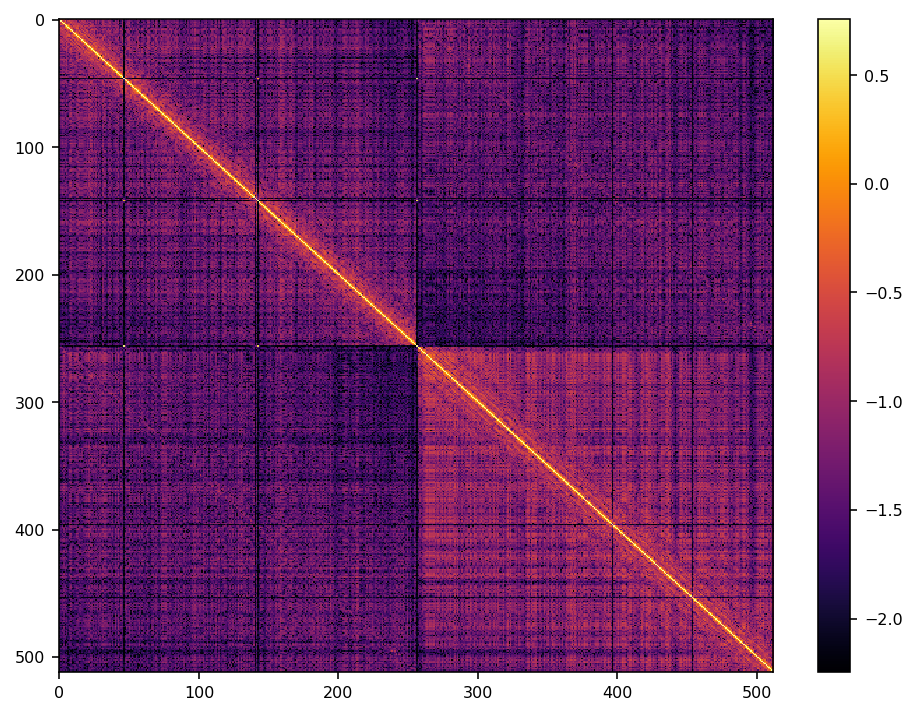

In [281]:
Cc = np.log10(np.abs(C[3]))
vmax = np.nanmedian(np.diag(Cc))
plt.imshow(Cc, vmin=(vmax - 3), vmax=vmax, interpolation="nearest")
plt.colorbar()

### Up-channelisation

FFT chunks of 128 times to do an upchannelisation similar to the absorber system

In [305]:
import scipy.fft

def upchannelize(x4: np.ndarray, chunksize: int = 128, exclude: list[int] | None = None) -> np.ndarray:
    
    M = x4.shape[0] // chunksize
    Nf, Ni = x4.shape[1:]
    
    Nt = 0
    
    up_out = np.zeros((M, x4.shape[1], chunksize), dtype=np.float32)
    
    for ci in range(M):
        
        x8c, N = decode(x4[(ci * chunksize):((ci + 1) * chunksize)])
        
        if exclude:
            x8c[..., exclude, :] = 0
        
        x8f = x8c.transpose(1, 2, 0, 3).astype(np.float32, order="C")
        x8f = x8f.view(np.complex64).reshape(Nf, Ni, chunksize)
        xf = scipy.fft.fft(x8f, axis=-1, workers=16)
        xu = np.fft.fftshift(xf, axes=-1)
        
        up_out[ci] = xu.var(axis=-2)
    
    return up_out

In [306]:
upo = upchannelize(rawdata, 128, mask)

This plot shows a number of different phenonema in the upchannelised data. Each chunk is a different (sparsely selected) frequency. The first one shows a bunch of junk, the second shows a bunch of high time resolution structure, and the third shows a narrow band transient lasting until about midway through the time range. The final one looks pretty clean.

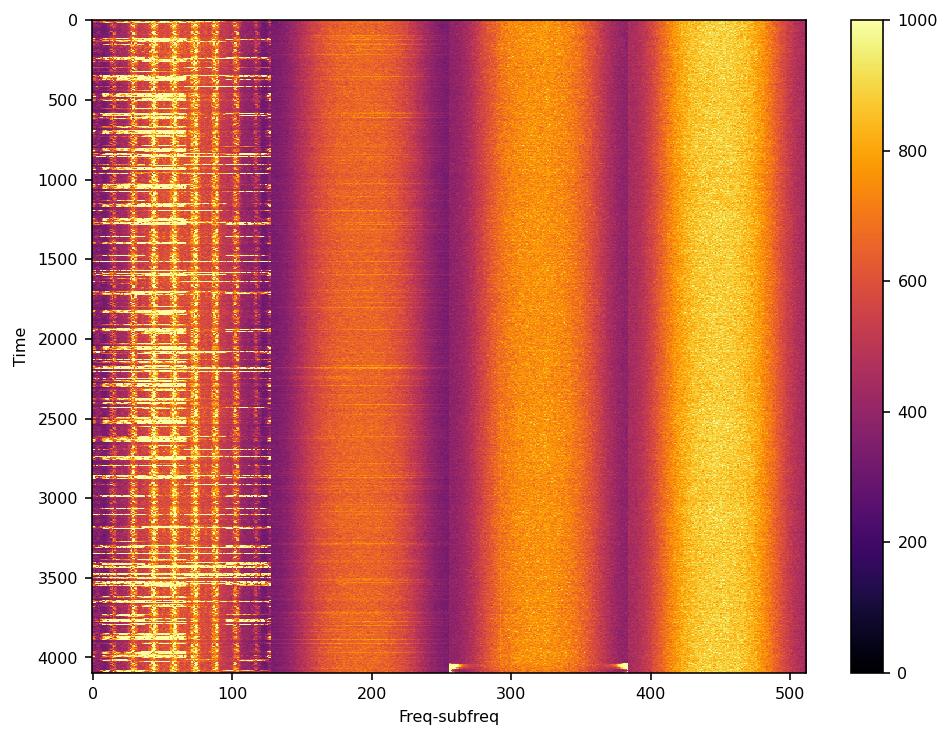

In [304]:
plt.imshow((upo[:, :].reshape(-1, 512)), vmin=0, vmax=1000)
plt.xlabel("Freq-subfreq")
plt.ylabel("Time")
plt.colorbar()